# Set-up

In [1]:
import os
import sys
import glob
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import pandas as pd

from PyComplexHeatmap import *
import seaborn as sns

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['pdf.fonttype'] = 42

In [2]:
results_dir = "/cellar/users/aklie/projects/igvf/topic_grn_links/eval/results"
dataset_name = "meta_analysis"
in_date = "03Sep23"

# TF metadata

In [3]:
# Read in the metadata
tf_metadata_df = pd.read_csv(os.path.join(results_dir, dataset_name, in_date, "tf_metadata_topics_baselines.tsv"), sep="\t", index_col=0)
len(tf_metadata_df)

709

In [4]:
# Sort by presence in literature
tf_metadata_df = tf_metadata_df.sort_values(by="in_literature", ascending=False)
tf_metadata_df.head()

,in_scenic,in_aracne,in_celloracle,in_literature,number_grns,in_topics,in_igvf_b01_LeftCortex,in_Bridge_Satpathy,in_both,in_neither
Mef2a,True,True,True,True,93,True,True,True,True,False
Runx1,True,False,True,True,76,True,True,True,True,False
Mef2c,True,True,True,True,87,True,True,True,True,False
Stat3,True,True,True,True,43,True,True,True,True,False
Sall1,True,True,False,True,29,True,True,True,True,False


# TF network scores

In [5]:
# Read in the network scores
tf_scores_df = pd.read_csv(os.path.join(results_dir, dataset_name, in_date, "tf_only_network_scores.tsv"), sep="\t").rename(columns={"Unnamed: 0": "tf_name"})
tf_scores_df.head()

,tf_name,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,grn_name
0,Runx1t1,2,0.004866,0,0.000000,2,0.004866,0.0,0.005795,Bridge_Satpathy_aracne_balanced_genotype_micro...
1,Runx1t1,50,0.142045,2,0.005682,48,0.136364,81.0,0.226653,Bridge_Satpathy_aracne_balanced_genotype_micro...
2,Runx1t1,37,0.099196,1,0.002681,36,0.096515,24.0,0.183886,Bridge_Satpathy_aracne_balanced_genotype_micro...
3,Runx1t1,1,0.001031,1,0.001031,0,0.000000,0.0,0.014566,Bridge_Satpathy_celloracle_balanced_genotype_m...
4,Runx1t1,1,0.001211,1,0.001211,0,0.000000,0.0,0.015317,Bridge_Satpathy_celloracle_balanced_genotype_m...


In [6]:
# Check to make sure all the tfs in the scores are in the metadata
(~tf_scores_df.tf_name.isin(tf_metadata_df.index)).sum()

0

# GRN metadata

In [7]:
# Read in all the network metadata
grn_metadata_df = pd.read_csv(os.path.join(results_dir, dataset_name, in_date, "cleaned_grn_metadata.tsv"), sep="\t", index_col=0)
len(grn_metadata_df)

120

## Violinplots across runs

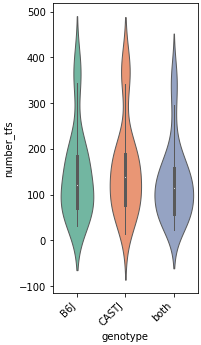

In [8]:
# Want a violin plot of with jitter
plt.figure(figsize=(3, 5))
sns.violinplot(
    data=grn_metadata_df,
    x="genotype",
    y="number_tfs",
    linewidth=1,
    palette="Set2",
)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

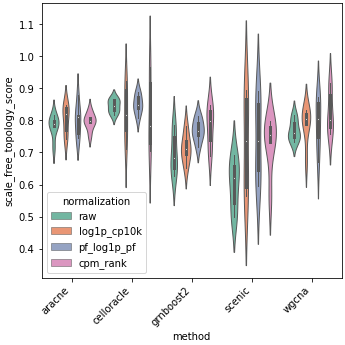

In [13]:
# Want a violin plot of with jitter
plt.figure(figsize=(5, 5))
sns.violinplot(
    data=grn_metadata_df,
    x="method",
    y="scale_free_topology_score",
    hue="normalization",
    linewidth=1,
    palette="Set2",
)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("/cellar/users/aklie/projects/igvf/topic_grn_links/external/igvf_annual_meetings/2023/scale_free_topology_score_violin.pdf")

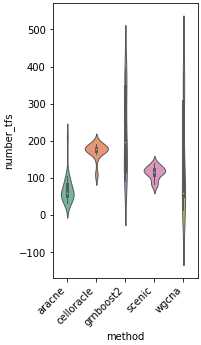

In [14]:
# Want a violin plot of with jitter
plt.figure(figsize=(3, 5))
sns.violinplot(
    data=grn_metadata_df,
    x="method",
    y="number_tfs",
    linewidth=1,
    palette="Set2",
)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 360x360 with 0 Axes>

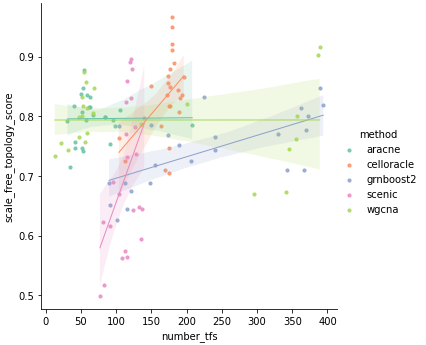

In [15]:
# lmplot with linear fits for each method of number_tfs vs scale_free_topology_score
plt.figure(figsize=(5, 5))
g = sns.lmplot(
    data=grn_metadata_df,
    x="number_tfs",
    y="scale_free_topology_score",
    hue="method",
    palette="Set2",
    scatter_kws={"s": 10},
    line_kws={"lw": 1},
)

## TF network score heatmap

In [16]:
# Let's start with just the both genotypes
grn_metadata_df = grn_metadata_df[grn_metadata_df["genotype"] == "both"]

In [17]:
# Create row annotation dataframe
df_rows = grn_metadata_df[["method", "dataset", "normalization", "genotype"]]
df_bar_tfs = grn_metadata_df[["number_tfs"]]
df_bar_connectivity = grn_metadata_df[["median_connectivity"]]
df_scatter = grn_metadata_df[["scale_free_topology_score"]]

In [18]:
# Create col annotation dataframe
df_cols = tf_metadata_df[["in_literature", "in_igvf_b01_LeftCortex"]].replace({True: "Yes", False: "No"})
df_bar = tf_metadata_df[["number_grns"]]

In [19]:
# Get a wide format dataframe based on the plot metric
plot_metric = "eigenvector_centrality"
df_heatmap = tf_scores_df.pivot_table(index="grn_name", columns="tf_name", values=plot_metric).fillna(0)

# Keep only GRNs that are in the metadata
df_heatmap = df_heatmap[df_heatmap.index.isin(grn_metadata_df.index)]

# Order by tf metadata
df_heatmap = df_heatmap[tf_metadata_df.index]

In [20]:
# Column annotations
row_ha = HeatmapAnnotation(
    Method=anno_simple(df_rows.method, legend=True, cmap="Set2"),
    Dataset=anno_simple(df_rows.dataset, legend=True, cmap="tab10"),
    Normalization=anno_simple(df_rows.normalization, legend=True, cmap="Paired"),
    #Genotype=anno_simple(df_rows.genotype, legend=False, cmap="Dark2"),
    ScaleFreeTopologyScore=anno_scatterplot(df_scatter, legend=False),
    MedianConnectivity=anno_barplot(df_bar_connectivity, legend=False),
    TFs=anno_barplot(df_bar_tfs, legend=False),
    axis=0,
)

# Row annotations
col_ha = HeatmapAnnotation(
    LiteratureTF=anno_simple(df_cols.in_literature, legend=False),
    NumGRNs=anno_barplot(df_bar, legend=False),
    axis=1
)

In [51]:
ClusterMapPlotter?

Init signature:
ClusterMapPlotter(
    data,
    z_score=None,
    standard_scale=None,
    top_annotation=None,
    bottom_annotation=None,
    left_annotation=None,
    right_annotation=None,
    row_cluster=True,
    col_cluster=True,
    row_cluster_method='average',
    row_cluster_metric='correlation',
    col_cluster_method='average',
    col_cluster_metric='correlation',
    show_rownames=False,
    show_colnames=False,
    row_names_side='right',
    col_names_side='bottom',
    row_dendrogram=False,
    col_dendrogram=False,
    row_dendrogram_size=10,
    col_dendrogram_size=10,
    row_split=None,
    col_split=None,
    dendrogram_kws=None,
    tree_kws=None,
    row_split_order=None,
    col_split_order=None,
    row_split_gap=0.5,
    col_split_gap=0.2,
    mask=None,
    subplot_gap=1,
    legend=True,
    legend_kws=None,
    plot=True,
    plot_legend=True,
    legend_anchor='auto',
    legend_gap=7,
    legend_width=None,
    legend_hpad=1,
    legend_vpad=5,
    leg

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/PyComplexHeatmap/clustermap.py:803: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..


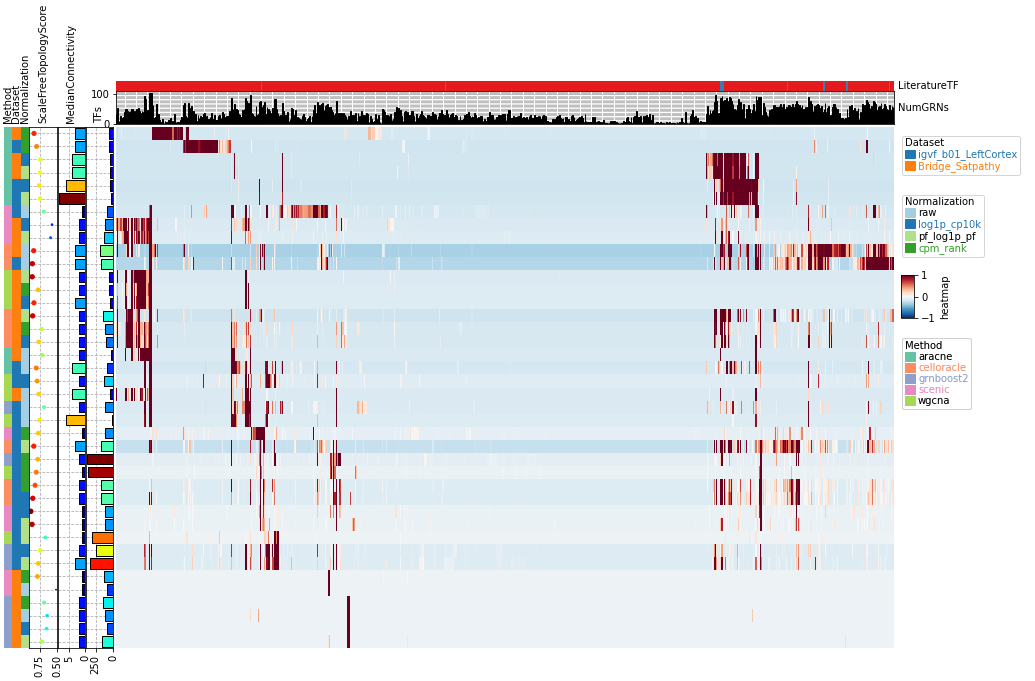

In [52]:
# Plot the heatmap
plt.figure(figsize=(16, 9))
cm = ClusterMapPlotter(
    data=df_heatmap,
    row_cluster=True,
    col_cluster=True,
    left_annotation=row_ha,
    top_annotation=col_ha,
    cmap="RdBu_r",
    z_score=0,
    vmin=-1,
    vmax=1,
)
plt.savefig("/cellar/users/aklie/projects/igvf/topic_grn_links/external/igvf_annual_meetings/2023/grn_heatmap.pdf")

# Look at TF rankings across methods for microglia TFs

In [23]:
# Grab a list of the tfs in the literature
lit_tfs = tf_metadata_df[tf_metadata_df["in_literature"]].index

In [24]:
# Grab scores for only the tfs in the literature
lit_tf_scores_df = tf_scores_df[tf_scores_df["tf_name"].isin(lit_tfs)]

In [25]:
# Add in the metadata for plotting
lit_tf_plot_df = lit_tf_scores_df.merge(grn_metadata_df, left_on="grn_name", right_index=True)
lit_tf_plot_df

,tf_name,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,grn_name,...,median_connectivity,max_connectivity,number_tfs,filtered_links_path,degree_centrality_out_path,eigenvector_centrality_path,betweenness_centrality_path,ulm_path,viper_path,aucell_path
3546,Sall1,1,0.001045,1,0.001045,0,0.000000,0.0,3.354018e-04,igvf_b01_LeftCortex_celloracle_balanced_genoty...,...,2.0,251.0,177,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...
4264,Mafb,4,0.004180,0,0.000000,4,0.004180,0.0,3.314819e-04,igvf_b01_LeftCortex_celloracle_balanced_genoty...,...,2.0,251.0,177,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...
7518,Irf8,8,0.008359,1,0.001045,7,0.007315,122.0,4.802226e-03,igvf_b01_LeftCortex_celloracle_balanced_genoty...,...,2.0,251.0,177,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...
8026,Stat3,15,0.015674,0,0.000000,15,0.015674,0.0,2.829429e-02,igvf_b01_LeftCortex_celloracle_balanced_genoty...,...,2.0,251.0,177,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...
11242,Mef2a,53,0.055381,1,0.001045,52,0.054336,55.0,9.404138e-02,igvf_b01_LeftCortex_celloracle_balanced_genoty...,...,2.0,251.0,177,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11283,Mef2a,4,0.005044,0,0.000000,4,0.005044,0.0,8.366173e-10,Bridge_Satpathy_grnboost2_balanced_genotype_mi...,...,2.0,268.0,148,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...
13832,Mef2c,1,0.001261,1,0.001261,0,0.000000,0.0,1.448977e-11,Bridge_Satpathy_grnboost2_balanced_genotype_mi...,...,2.0,268.0,148,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...
11315,Mef2a,8,0.016771,0,0.000000,8,0.016771,0.0,0.000000e+00,Bridge_Satpathy_wgcna_balanced_genotype_microg...,...,2.0,334.0,57,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/proj

## Plot based on GRN node scores

In [26]:
# Get orders for plotting
order = lit_tf_plot_df.groupby("tf_name").mean().sort_values(by=plot_metric, ascending=False).index
hue_order = lit_tf_plot_df.groupby("method").mean().sort_values(by=plot_metric, ascending=False).index

(0.0, 166.95)

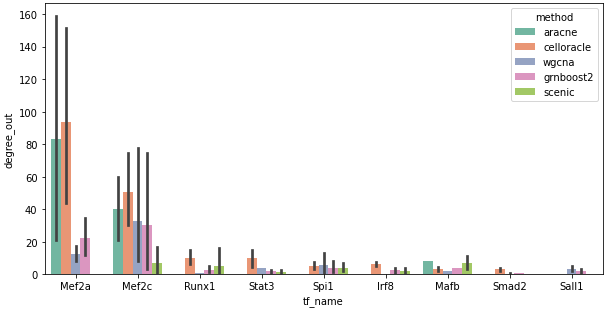

In [28]:
# Want a violin plot of eigenvector_centrality for each TF colored by method
plt.figure(figsize=(10, 5))
sns.barplot(
    data=lit_tf_plot_df,
    x="tf_name",
    y="degree_out",
    hue="method",
    linewidth=1,
    palette="Set2",
    order=order,
    hue_order=hue_order,
)
# Set min at 0
plt.ylim(bottom=0)

## Rankings from GRNs

In [29]:
rankings = ["aucell", "betweenness_centrality", "eigenvector_centrality", "degree_centrality_out", "ulm"]
lit_tf_ranking_plot_df = lit_tf_plot_df.set_index(["tf_name", "grn_name"])
for ranking in rankings:
    rank_list = []
    for i, ((tf_name, grn_name), row) in enumerate(lit_tf_ranking_plot_df.iterrows()):
        df =  pd.read_csv(row[f"{ranking}_path"], sep="\t", index_col=0)
        if tf_name in df.index:
            rank_list.append(df.loc[tf_name, "rank"]/len(df))
        else:
            rank_list.append(np.nan)
    lit_tf_ranking_plot_df[f"{ranking}_rank"] = rank_list
lit_tf_ranking_plot_df = lit_tf_ranking_plot_df.reset_index()

In [30]:
# Add in the best rank across
lit_tf_ranking_plot_df["best_rank"] = lit_tf_ranking_plot_df[[ranking + "_rank" for ranking in rankings]].min(axis=1)
lit_tf_ranking_plot_df["avg_rank"] = lit_tf_ranking_plot_df[[ranking + "_rank" for ranking in rankings]].mean(axis=1)

In [31]:
# Get orders for plotting
order = lit_tf_ranking_plot_df.groupby("tf_name").median().sort_values(by="best_rank").index
hue_order = lit_tf_ranking_plot_df.groupby("method").median().sort_values(by="best_rank").index

<Axes: xlabel='tf_name', ylabel='best_rank'>

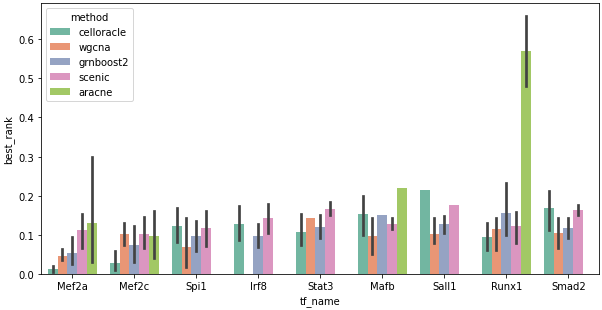

In [32]:
# Want a violin plot of eigenvector_centrality for each TF colored by method
plt.figure(figsize=(10, 5))
sns.barplot(
    data=lit_tf_ranking_plot_df,
    x="tf_name",
    y="best_rank",
    hue="method",
    linewidth=1,
    palette="Set2",
    order=order,
    hue_order=hue_order,
)

## Load in baselines

In [33]:
# Read in the metadata
baseline_metadata_df = pd.read_csv(os.path.join(results_dir, dataset_name, in_date, "cleaned_baseline_metadata.tsv"), sep="\t", index_col=0)
len(baseline_metadata_df)

24

In [34]:
# Keep only "both" genotype
baseline_metadata_df = baseline_metadata_df[baseline_metadata_df["genotype"] == "both"]

In [35]:
# Get baseline rankings
rankings = ["expression", "ulm", "viper", "aucell"]
ranks = {}
lit_tf_ranking_baseline_tf = pd.DataFrame(index=lit_tfs, columns=[ranking + "_rank" for ranking in rankings])
for ranking in rankings:
    ranks[f"{ranking}_rank"] = {}
    for i, (grn_name, row) in enumerate(baseline_metadata_df.iterrows()):
        df =  pd.read_csv(row[f"{ranking}_path"], sep="\t", index_col=0)
        ranks[f"{ranking}_rank"][grn_name] = {}
        for tf_name in lit_tfs:
            if tf_name in df.index:
                ranks[f"{ranking}_rank"][grn_name][tf_name] = df.loc[tf_name, "rank"]/len(df)
            else:
                ranks[f"{ranking}_rank"][grn_name][tf_name] = np.nan

In [36]:
# Pull out expression ranks
expression_df = pd.DataFrame(ranks["expression_rank"])
expression_df = expression_df.melt(value_name="best_rank", var_name="grn_name", ignore_index=False).reset_index()
expression_df["tf_name"] = expression_df["index"]
expression_df["method"] = "expression"
expression_df.drop(columns=["index"], inplace=True)

In [37]:
# Pull out dorothea ulm ranks
ulm_df = pd.DataFrame(ranks["ulm_rank"])
ulm_df = ulm_df.melt(value_name="best_rank", var_name="grn_name", ignore_index=False).reset_index()
ulm_df["tf_name"] = ulm_df["index"]
ulm_df["method"] = "dorothea_ulm"
ulm_df.drop(columns=["index"], inplace=True)

In [38]:
# Add to the dataframe
lit_tf_ranking_plot_df = pd.concat([lit_tf_ranking_plot_df, expression_df, ulm_df])

In [39]:
# Get orders for plotting
order = lit_tf_ranking_plot_df.groupby("tf_name").median().sort_values(by="best_rank").index
hue_order = lit_tf_ranking_plot_df.groupby("method").median().sort_values(by="best_rank").index

In [40]:
hue_order = ['celloracle', 'wgcna', 'grnboost2', 'scenic', 'aracne', 'dorothea_ulm', 'expression']

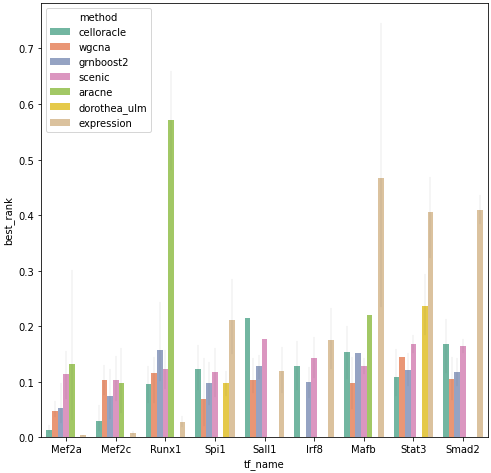

In [50]:
# Want a violin plot of eigenvector_centrality for each TF colored by method, with no error bars
plt.figure(figsize=(8, 8))
sns.barplot(
    data=lit_tf_ranking_plot_df,
    x="tf_name",
    y="best_rank",
    hue="method",
    linewidth=1,
    palette="Set2",
    order=order,
    hue_order=hue_order,
    errwidth=0.1,
)
# Set min at 0
plt.ylim(bottom=0)

plt.savefig("/cellar/users/aklie/projects/igvf/topic_grn_links/external/igvf_annual_meetings/2023/tf_ranking.pdf")

# Cross genotype comparisons

In [ ]:
topic_metadata_df = pd.read_csv(os.path.join(results_dir, dataset_name, in_date, "cleaned_topic_metadata.tsv"), sep="\t", index_col=0)

In [438]:
# Want a violin plot of eigenvector_centrality for each TF colored by method
plt.figure(figsize=(10, 5))
sns.barplot(
    data=grn_metadata_df,
    x="tf_name",
    y="degree_out",
    hue="method",
    linewidth=1,
    palette="Set2",
    order=order,
    hue_order=hue_order,
)
# Set min at 0
plt.ylim(bottom=0)

,dataset,method,cells,genes,normalization,genotype,scale_free_topology_score,mean_connectivity,median_connectivity,max_connectivity,...,aucell_path,Mef2a_rank,Runx1_rank,Mef2c_rank,Stat3_rank,Sall1_rank,Irf8_rank,Spi1_rank,Smad2_rank,Mafb_rank
grn_name,,,,,,,,,,,,,,,,,,,,,
igvf_b01_LeftCortex_aracne_balanced_genotype_microglia_B6J_0.05_raw,igvf_b01_LeftCortex,aracne,balanced_genotype_microglia,0.05,raw,B6J,0.782986,6.568144,3.0,186.0,...,/cellar/users/aklie/projects/igvf/topic_grn_li...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
igvf_b01_LeftCortex_aracne_balanced_genotype_microglia_CASTJ_0.05_raw,igvf_b01_LeftCortex,aracne,balanced_genotype_microglia,0.05,raw,CASTJ,0.784745,3.970117,2.0,96.0,...,/cellar/users/aklie/projects/igvf/topic_grn_li...,7.0,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN
igvf_b01_LeftCortex_aracne_balanced_genotype_microglia_both_0.05_raw,igvf_b01_LeftCortex,aracne,balanced_genotype_microglia,0.05,raw,both,0.799480,7.920792,4.0,239.0,...,/cellar/users/aklie/projects/igvf/topic_grn_li...,1.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
igvf_b01_LeftCortex_aracne_balanced_genotype_microglia_B6J_0.05_log1p_cp10k,igvf_b01_LeftCortex,aracne,balanced_genotype_microglia,0.05,log1p_cp10k,B6J,0.837918,10.416667,5.0,128.0,...,/cellar/users/aklie/projects/igvf/topic_grn_li...,5.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
igvf_b01_LeftCortex_aracne_balanced_genotype_microglia_CASTJ_0.05_log1p_cp10k,igvf_b01_LeftCortex,aracne,balanced_genotype_microglia,0.05,log1p_cp10k,CASTJ,0.835523,10.666667,5.0,135.0,...,/cellar/users/aklie/projects/igvf/topic_grn_li...,14.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bridge_Satpathy_wgcna_balanced_genotype_microglia_CASTJ_0.05_log1p_cp10k,Bridge_Satpathy,wgcna,balanced_genotype_microglia,0.05,log1p_cp10k,CASTJ,0.813745,9.070295,3.0,337.0,...,/cellar/users/aklie/projects/igvf/topic_grn_li...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bridge_Satpathy_wgcna_balanced_genotype_microglia_both_0.05_log1p_cp10k,Bridge_Satpathy,wgcna,balanced_genotype_microglia,0.05,log1p_cp10k,both,0.833126,9.216590,3.0,336.0,...,/cellar/users/aklie/projects/igvf/topic_grn_li...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bridge_Satpathy_wgcna_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf,Bridge_Satpathy,wgcna,balanced_genotype_microglia,0.05,pf_log1p_pf,B6J,0.874247,8.368201,3.0,310.0,...,/cellar/users/aklie/projects/igvf/topic_grn_li...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [412]:
lit_tf_plot_df

,tf_name,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality,grn_name,...,Bridge_Satpathy_wgcna_balanced_genotype_microglia_both_0.05_raw,Bridge_Satpathy_wgcna_balanced_genotype_microglia_B6J_0.05_cpm_rank,Bridge_Satpathy_wgcna_balanced_genotype_microglia_CASTJ_0.05_cpm_rank,Bridge_Satpathy_wgcna_balanced_genotype_microglia_both_0.05_cpm_rank,Bridge_Satpathy_wgcna_balanced_genotype_microglia_B6J_0.05_log1p_cp10k,Bridge_Satpathy_wgcna_balanced_genotype_microglia_CASTJ_0.05_log1p_cp10k,Bridge_Satpathy_wgcna_balanced_genotype_microglia_both_0.05_log1p_cp10k,Bridge_Satpathy_wgcna_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf,Bridge_Satpathy_wgcna_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf,Bridge_Satpathy_wgcna_balanced_genotype_microglia_both_0.05_pf_log1p_pf
3542,Sall1,2.0,0.005222,1.0,0.002611,1.0,0.002611,0.0,0.023220,igvf_b01_LeftCortex_aracne_balanced_genotype_m...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11225,Mef2a,51.0,0.133159,3.0,0.007833,48.0,0.125326,206.0,0.309695,igvf_b01_LeftCortex_aracne_balanced_genotype_m...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13775,Mef2c,36.0,0.093995,2.0,0.005222,34.0,0.088773,70.0,0.181511,igvf_b01_LeftCortex_aracne_balanced_genotype_m...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17968,Runx1,1.0,0.002611,1.0,0.002611,0.0,0.000000,0.0,0.004461,igvf_b01_LeftCortex_aracne_balanced_genotype_m...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3543,Sall1,1.0,0.002674,0.0,0.000000,1.0,0.002674,0.0,0.000717,igvf_b01_LeftCortex_aracne_balanced_genotype_m...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mafb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stat3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Spi1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Smad2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [342]:
methods = ["celloracle"]
normalizations = ["pf_log1p_pf"]
ranking_metadata_df = grn_metadata_df[grn_metadata_df["method"].isin(methods) & grn_metadata_df["normalization"].isin(normalizations)]
ranking_metadata_df

,dataset,method,cells,genes,normalization,genotype,scale_free_topology_score,mean_connectivity,median_connectivity,max_connectivity,number_tfs,filtered_links_path,degree_centrality_out_path,eigenvector_centrality_path,betweenness_centrality_path,ulm_path,viper_path,aucell_path
grn_name,,,,,,,,,,,,,,,,,,
igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf,igvf_b01_LeftCortex,celloracle,balanced_genotype_microglia,0.05,pf_log1p_pf,B6J,0.889136,5.340454,3.0,57.0,182,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...
igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf,igvf_b01_LeftCortex,celloracle,balanced_genotype_microglia,0.05,pf_log1p_pf,CASTJ,0.878897,5.563282,3.0,66.0,177,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...
igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_both_0.05_pf_log1p_pf,igvf_b01_LeftCortex,celloracle,balanced_genotype_microglia,0.05,pf_log1p_pf,both,0.835246,5.471956,3.0,193.0,172,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...
Bridge_Satpathy_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf,Bridge_Satpathy,celloracle,balanced_genotype_microglia,0.05,pf_log1p_pf,B6J,0.807120,5.427408,3.0,197.0,189,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...
Bridge_Satpathy_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf,Bridge_Satpathy,celloracle,balanced_genotype_microglia,0.05,pf_log1p_pf,CASTJ,0.844570,5.738881,2.0,185.0,188,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...
Bridge_Satpathy_celloracle_balanced_genotype_microglia_both_0.05_pf_log1p_pf,Bridge_Satpathy,celloracle,balanced_genotype_microglia,0.05,pf_log1p_pf,both,0.851157,6.379585,2.0,237.0,150,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...
igvf_b01_LeftCortex_scenic_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf,igvf_b01_LeftCortex,scenic,balanced_genotype_microglia,0.05,pf_log1p_pf,B6J,0.891132,3.051106,1.0,71.0,120,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/projects/igvf/topic_grn_li...,/cellar/users/aklie/proj

In [359]:
ranking_file_cols = ranking_metadata_df.columns[ranking_metadata_df.columns.str.contains("path")]
ranking_file_cols = ranking_file_cols[ranking_file_cols != "filtered_links_path"]
ranking_file_cols = ranking_file_cols[ranking_file_cols != "viper_path"]
ranking_file_cols

Index(['degree_centrality_out_path', 'eigenvector_centrality_path',
       'betweenness_centrality_path', 'ulm_path', 'aucell_path'],
      dtype='object')

  0%|          | 0/12 [00:00<?, ?it/s]

In [394]:
# Make a rank only dataframe
rank_only_df = rank_df.copy()
rank_only_df = rank_only_df[rank_only_df.columns[rank_only_df.columns.str.contains("rank")]]
rank_only_df

,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf_degree_centrality_out_rank,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf_eigenvector_centrality_rank,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf_betweenness_centrality_rank,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf_ulm_rank,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf_aucell_rank,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_degree_centrality_out_rank,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_eigenvector_centrality_rank,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_betweenness_centrality_rank,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_ulm_rank,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_aucell_rank,...,Bridge_Satpathy_scenic_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_degree_centrality_out_rank,Bridge_Satpathy_scenic_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_eigenvector_centrality_rank,Bridge_Satpathy_scenic_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_betweenness_centrality_rank,Bridge_Satpathy_scenic_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_ulm_rank,Bridge_Satpathy_scenic_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_aucell_rank,Bridge_Satpathy_scenic_balanced_genotype_microglia_both_0.05_pf_log1p_pf_degree_centrality_out_rank,Bridge_Satpathy_scenic_balanced_genotype_microglia_both_0.05_pf_log1p_pf_eigenvector_centrality_rank,Bridge_Satpathy_scenic_balanced_genotype_microglia_both_0.05_pf_log1p_pf_betweenness_centrality_rank,Bridge_Satpathy_scenic_balanced_genotype_microglia_both_0.05_pf_log1p_pf_ulm_rank,Bridge_Satpathy_scenic_balanced_genotype_microglia_both_0.05_pf_log1p_pf_aucell_rank
Mef2a,1.0,1.0,9.0,1.0,15.0,2.0,2.0,1.0,1.0,32.0,...,138.0,10.0,25.0,NaN,NaN,136.0,13.0,23.0,NaN,NaN
Runx1,76.0,30.0,19.0,77.0,51.0,93.0,8.0,5.0,37.0,8.0,...,138.0,78.0,25.0,NaN,NaN,136.0,79.0,23.0,NaN,NaN
Mef2c,4.0,3.0,1.0,2.0,20.0,5.0,4.0,2.0,2.0,9.0,...,138.0,51.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stat3,67.0,64.0,40.0,45.0,43.0,40.0,58.0,41.0,51.0,74.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sall1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Brd4,183.0,155.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zfp969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Smad3,135.0,162.0,40.0,110.0,40.0,71.0,119.0,41.0,67.0,57.0,...,31.0,53.0,25.0,14.0,10.0,74.0,96.0,23.0,NaN,NaN
Zfp91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,138.0,59.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [396]:
lit_rank_df = rank_only_df[rank_only_df.index.isin(lit_tfs)]
lit_rank_df

,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf_degree_centrality_out_rank,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf_eigenvector_centrality_rank,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf_betweenness_centrality_rank,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf_ulm_rank,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf_aucell_rank,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_degree_centrality_out_rank,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_eigenvector_centrality_rank,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_betweenness_centrality_rank,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_ulm_rank,igvf_b01_LeftCortex_celloracle_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_aucell_rank,...,Bridge_Satpathy_scenic_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_degree_centrality_out_rank,Bridge_Satpathy_scenic_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_eigenvector_centrality_rank,Bridge_Satpathy_scenic_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_betweenness_centrality_rank,Bridge_Satpathy_scenic_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_ulm_rank,Bridge_Satpathy_scenic_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf_aucell_rank,Bridge_Satpathy_scenic_balanced_genotype_microglia_both_0.05_pf_log1p_pf_degree_centrality_out_rank,Bridge_Satpathy_scenic_balanced_genotype_microglia_both_0.05_pf_log1p_pf_eigenvector_centrality_rank,Bridge_Satpathy_scenic_balanced_genotype_microglia_both_0.05_pf_log1p_pf_betweenness_centrality_rank,Bridge_Satpathy_scenic_balanced_genotype_microglia_both_0.05_pf_log1p_pf_ulm_rank,Bridge_Satpathy_scenic_balanced_genotype_microglia_both_0.05_pf_log1p_pf_aucell_rank
Mef2a,1.0,1.0,9.0,1.0,15.0,2.0,2.0,1.0,1.0,32.0,...,138.0,10.0,25.0,NaN,NaN,136.0,13.0,23.0,NaN,NaN
Runx1,76.0,30.0,19.0,77.0,51.0,93.0,8.0,5.0,37.0,8.0,...,138.0,78.0,25.0,NaN,NaN,136.0,79.0,23.0,NaN,NaN
Mef2c,4.0,3.0,1.0,2.0,20.0,5.0,4.0,2.0,2.0,9.0,...,138.0,51.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stat3,67.0,64.0,40.0,45.0,43.0,40.0,58.0,41.0,51.0,74.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sall1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Irf8,47.0,13.0,40.0,4.0,4.0,71.0,67.0,41.0,34.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Spi1,67.0,52.0,40.0,61.0,55.0,93.0,117.0,41.0,83.0,55.0,...,104.0,150.0,24.0,NaN,NaN,74.0,159.0,23.0,NaN,NaN
Smad2,158.0,202.0,40.0,NaN,NaN,132.0,128.0,41.0,134.0,117.0,...,55.0,89.0,25.0,46.0,44.0,NaN,NaN,NaN,NaN,NaN
Mafb,52.0,120.0,40.0,88.0,104.0,81.0,151.0,41.0,129.0,128.0,...,70.0,122.0,25.0,NaN,NaN,39.0,50.0,23.0,27.0,22.0


In [397]:
# Remove "_rank" from the column names
lit_rank_df.columns = lit_rank_df.columns.str.replace("_rank", "")

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Plotting legends..


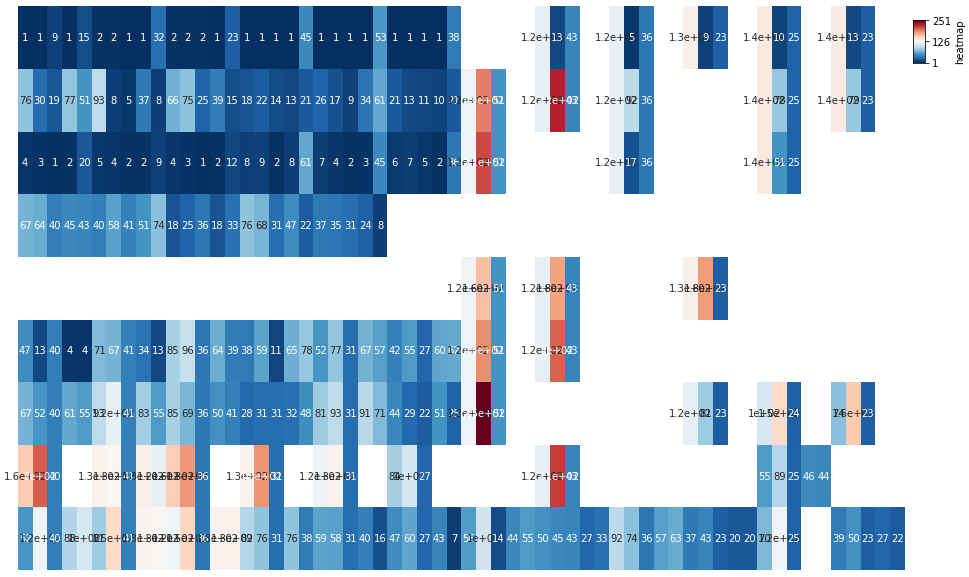

In [398]:
# Plot a heatmap of the ranks
plt.figure(figsize=(16, 9))
cm = ClusterMapPlotter(
    data=lit_rank_df,
    row_cluster=False,
    col_cluster=False,
    cmap="RdBu_r",
    annot=True,
)

In [ ]:
# Keep 

# Scratch

In [5]:
#Generate example dataset (random)
df = pd.DataFrame(['AAAA1'] * 5 + ['BBBBB2'] * 5, columns=['AB'])
df['CD'] = ['C'] * 3 + ['D'] * 3 + ['G'] * 4
df['EF'] = ['E'] * 6 + ['F'] * 2 + ['H'] * 2
df['F'] = np.random.normal(0, 1, 10)
df.index = ['sample' + str(i) for i in range(1, df.shape[0] + 1)]
df_box = pd.DataFrame(np.random.randn(10, 4), columns=['Gene' + str(i) for i in range(1, 5)])
df_box.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_bar = pd.DataFrame(np.random.uniform(0, 10, (10, 2)), columns=['TMB1', 'TMB2'])
df_bar.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_scatter = pd.DataFrame(np.random.uniform(0, 10, 10), columns=['Scatter'])
df_scatter.index = ['sample' + str(i) for i in range(1, df_box.shape[0] + 1)]
df_heatmap = pd.DataFrame(np.random.randn(30, 10), columns=['sample' + str(i) for i in range(1, 11)])
df_heatmap.index = ["Fea" + str(i) for i in range(1, df_heatmap.shape[0] + 1)]
df_heatmap.iloc[1, 2] = np.nan

In [9]:
df.head(2)

,AB,CD,EF,F
sample1,AAAA1,C,E,-1.544247
sample2,AAAA1,C,E,-0.691809


In [10]:
df_box.head(2)

,Gene1,Gene2,Gene3,Gene4
sample1,0.041717,1.709456,0.213025,-0.083720
sample2,0.613914,0.811163,0.798177,-0.847621


In [11]:
df_bar.head(2)

,TMB1,TMB2
sample1,5.174482,5.058348
sample2,1.744210,7.263465


In [17]:
df_scatter.head()

,Scatter
sample1,7.227794
sample2,4.573205
sample3,3.976640
sample4,3.976429
sample5,3.782117


In [13]:
df_heatmap.head(2)

,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,sample10
Fea1,0.745766,-0.965421,-0.191685,-0.012752,-1.758579,-0.831034,-0.381804,-0.939713,0.093533,-0.811466
Fea2,-0.027302,-1.310062,NaN,1.316942,0.213814,0.046216,-0.270608,-2.112667,-0.498841,1.841745


Starting plotting HeatmapAnnotations


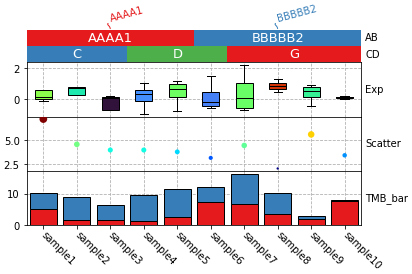

In [15]:
plt.figure(figsize=(6, 4))
col_ha = HeatmapAnnotation(label=anno_label(df.AB, merge=True,rotation=15),
                            AB=anno_simple(df.AB,add_text=True,legend=True), axis=1,
                            CD=anno_simple(df.CD,add_text=True,legend=True),
                            Exp=anno_boxplot(df_box, cmap='turbo',legend=True),
                            Scatter=anno_scatterplot(df_scatter), TMB_bar=anno_barplot(df_bar,legend=True),
                           plot=True,legend=True,plot_legend=False,
                           legend_gap=5,hgap=0)
col_ha.show_ticklabels(df.index.tolist())
plt.show()